### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [40]:
import string
import os 

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [372]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [375]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
lines = text
text = "".join([line.lower() for line in text])

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [379]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [481]:
# dict <index>:<char>
# Your great code here
token_to_id = dict(zip(tokens, range(len(tokens))))

# dict <char>:<index>
# Your great code here
id_to_token = dict(zip(token_to_id.values(), token_to_id.keys()))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [486]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

In [489]:
# Your code here
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):

        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=-1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        
        logits = self.rnn_to_logits(h_next) # YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [491]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [494]:
# Your plot code here

def rnn_loop(char_rnn, batch_ix):

    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state) 
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [496]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c.lower()] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: 
        names_ix = np.transpose(names_ix)

    return names_ix

In [507]:
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(ls).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (len(tokens),)

In [509]:
from IPython.display import clear_output
from random import sample

In [511]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())

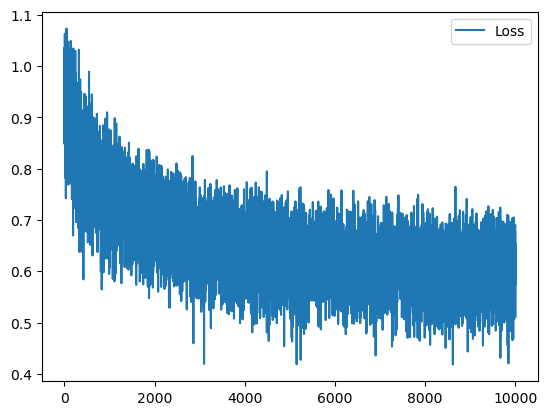

In [521]:
MAX_LENGTH = 100
loss_x = []

for i in range(10000):
    
    opt.zero_grad()
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    predictions_logp = logp_seq[:, :-1] # YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:] # YOUR CODE HERE
    loss = criterion(
        predictions_logp.contiguous().view(-1, len(tokens)),
        actual_next_tokens.contiguous().view(-1)
    ) 
    loss.backward()
    opt.step()
    loss_x.append(loss.data.numpy())

plt.plot(loss_x,label='Loss')
plt.legend()
plt.show()

In [529]:
def generate_sample(char_rnn, seed_phrase='in a while', max_length=500, temperature=0.5):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [531]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

for temp in [0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 2]:
    print('====================\n')
    print(f'Temp = {temp}')
    print(generate_sample(char_rnn, seed_phrase = ' hello darkness my', temperature=temp))


Temp = 0.1
 hello darkness my strong the strong the worth the strong the strong the worth the worth the strong the worth the worth the worth the worth the worth the worth the worth the worth the worth the worth the worth the worth the worth the strong the worth the worth the worth the worth the worth the worth the worth the strong the worth the will the worth the worth the worth the still the worth the love the worth the worth the still the worth the strong the worth the worth the worth the worth the worth

Temp = 0.2
 hello darkness my love the worth the will the love the worth the worth the worth heart the worth should the world in the strong the state the strong the worth the will the waste the waste the worth the strong the world the comble with the worth the strong the with the love the worth the will the love the self the part the strong the stake the worth the stare the still the worth the in the show the cantering the worth should the will the worth the strong the worth the wa

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [46]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT